# Grover's Algorithm
A fast algorithm to find _a_ solution states from $N$ total states($M$ of which are solution states) with high probability. 
<br/>
In particular, the probability of finding a valid solution is $\sin^2(\frac{\theta}{2} + k\theta$), where $k$ is the number of Grover iterations and $\theta = 2\sin^{-1}(M/N)$. $k$ is chosen so as to make the probability high. 

In [567]:
from qiskit import Aer, QuantumCircuit, assemble, transpile
from qiskit.circuit.library.standard_gates import XGate, ZGate
sim = Aer.get_backend('aer_simulator')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [568]:
def oracle(n, s: str):
    ckt = QuantumCircuit(n+1)
    for i in range(n):
        if s[i] == "1": ckt.x(i)
    ckt = ckt.compose(XGate().control(num_ctrl_qubits=n))
    for i in range(n):
        if s[i] == "1": ckt.x(i) # get the X'd qubits back to old state
    return ckt#.to_gate(label="   Oracle   ")

In [569]:
def Grover_iteration(ckt, n, oracle):
    ckt = ckt.compose(oracle)
    ckt.barrier()
    
    for i in range(n): ckt.h(i)
    ckt.barrier()

    ckt = ckt.compose(conditional_phase_ckt(n))
    ckt.barrier()

    for i in range(n): ckt.h(i)
    ckt.barrier()
    
    return ckt

In [570]:
def conditional_phase_ckt(n):
    ckt = QuantumCircuit(n)
    for i in range(n): ckt.x(i)
    cz = ZGate().control(num_ctrl_qubits=n-1)
    ckt = ckt.compose(cz)
    for i in range(n): ckt.x(i)
    #return ckt.to_gate(label="Conditional \n Phase \n Circuit")
    return ckt

In [571]:
from math import pi, sqrt, asin
def find_solutions_by_Grover(n, oracle, M=1):
    ckt = QuantumCircuit(n + 1, n)
    ckt.x(n)
    for i in range(n+1): ckt.h(i)
    ckt.barrier()

    # now we apply the k Grover iterations to get to a state that will measure to a solution state with high probability
    theta = 2*asin(sqrt(M/(2**n))) # N = 2**n
    print("theta is approx", round(theta*180/pi), "degrees")
    k = round(pi/(2*theta) - 0.5)
    print("number of iterations(k) is", k)
    for _ in range(k):
        ckt = Grover_iteration(ckt, n, oracle)
        #print(ckt)
    for i in range(n): 
        ckt.measure(i, i)

    transpiled_ckt = transpile(ckt, sim) # convert (non-standard)gates like c3z so that the backend understands them.
    qobj = assemble(transpiled_ckt) # now assemble to a qobj and run 
    
    possible_solutions = sim.run(qobj).result().get_counts()
    possible_solutions = [(int(key, 2), value) for key, value in possible_solutions.items()]
    possible_solutions = sorted(possible_solutions, key=lambda item: item[1], reverse=True)

    return ckt, possible_solutions

theta is approx 14 degrees
number of iterations(k) is 6


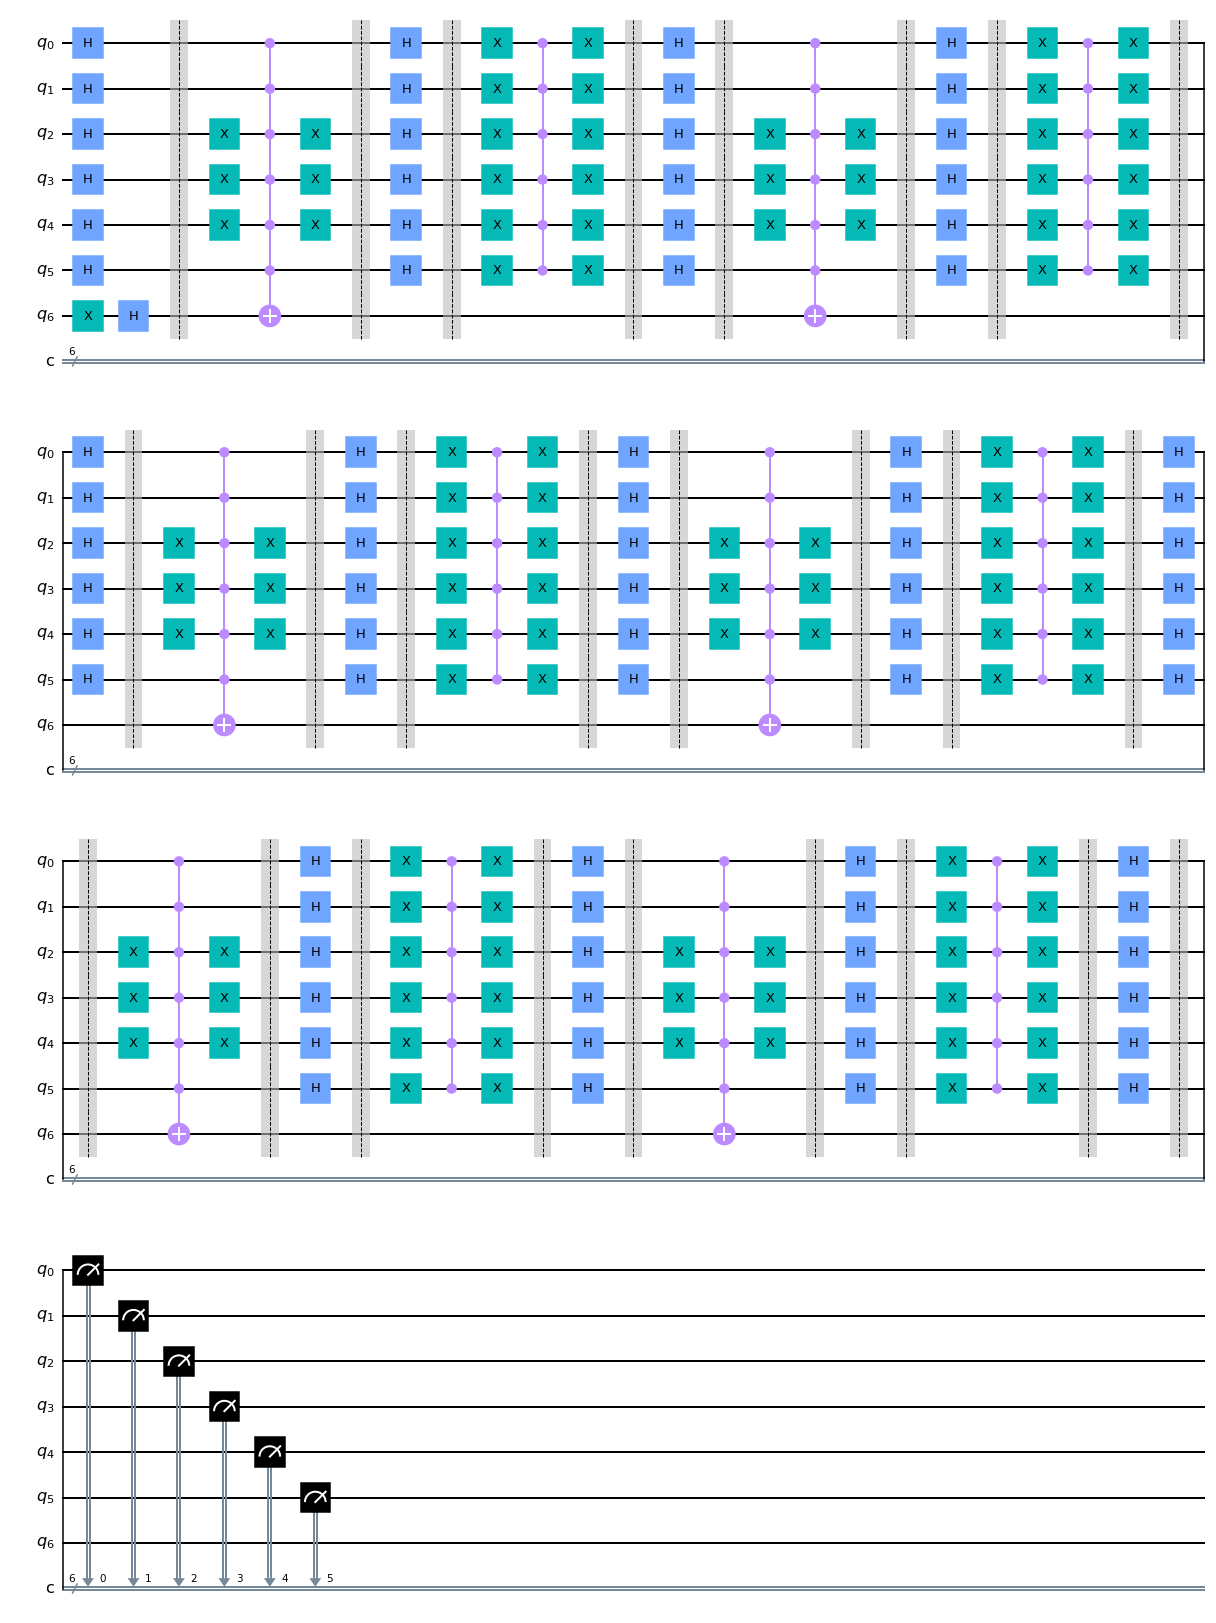

[(35, 1016), (20, 1), (39, 1), (10, 1), (46, 1), (42, 1), (19, 1), (29, 1), (0, 1)]


In [572]:
from random import randint

n = 6
s = ""
for i in range(n): 
    s += ("1" if randint(0, 1) else "0")

ckt, possible_solutions = find_solutions_by_Grover(n, oracle(n, s), M=1)
ckt.draw("mpl")
print(possible_solutions)